## Stacked Convolutional Recurrent Neural Networks

In [1]:
import os
os.environ["PYTHONHASHSEED"] = "0"

import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle

In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Reshape, Bidirectional
from keras.layers.wrappers import TimeDistributed
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
#SET PATHS
dataspace = '/vol/vssp/datasets/audio01/UrbanSound8K/audio/'
projectspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

metadatafile = '/vol/vssp/datasets/audio01/UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadatafile)

hdf5_path = os.path.join(projectspace,'dataset.hdf5') 
modelfolder = os.path.join(projectspace,'models')
scalerpath = os.path.join(projectspace,'scaler.pkl')

In [5]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [6]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]

# CHANGE DIMENSION TO FIT KERAS
X_train = np.expand_dims(X_train_scaled, 3)
X_val = np.expand_dims(X_val_scaled, 3)
X_test = np.expand_dims(X_test_scaled, 3)

In [7]:
def build_crnn(n_frames=n_frames, n_features=n_features,  n_filters_cnn=48,
                     filter_size_cnn=(5, 5), pool_size_cnn=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features,  1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(x)
    y = MaxPooling2D(pool_size=(1,2), strides=None, padding='same')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=(1,2), strides=None, padding='same')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=(1,2), strides=None, padding='same')(y)
    y = BatchNormalization()(y)
    
    # CONV 4
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=(1,5), strides=None, padding='same')(y)
    y = BatchNormalization()(y)
    
    y = Reshape((n_frames, n_filters_cnn))(y)
    
    #y = Dropout(0.5)(y)
    y= LSTM(120)(y)
    #y = Dropout(0.5)(y)
    #y = Dense(n_dense_cnn, activation='relu')(y)

    #y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [8]:
m = build_crnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 173, 40, 48)       1248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 173, 20, 48)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 173, 20, 48)       192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 173, 20, 48)       57648     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 173, 10, 48)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 173, 10, 48)       192       
__________

In [18]:
from keras.utils import plot_model
plot_model(m, to_file='figures/crnn_model_shape.png', show_shapes=True)

<img src='figures/crnn_model_shape.png'>

In [10]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model_checkpoint = ModelCheckpoint(
    os.path.join(modelfolder, 'crnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
    monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]<img src='figures/crnn_model.png'>

history = m.fit(x=X_train, y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_split=0.0,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 41s 6ms/step - loss: 2.7309 - acc: 0.3420 - val_loss: 2.9480 - val_acc: 0.1593
Epoch 2/200
7079/7079 [==============================] - 35s 5ms/step - loss: 1.9918 - acc: 0.4875 - val_loss: 2.8024 - val_acc: 0.2230
Epoch 3/200
7079/7079 [==============================] - 35s 5ms/step - loss: 1.9979 - acc: 0.4943 - val_loss: 3.2143 - val_acc: 0.0956
Epoch 4/200
7079/7079 [==============================] - 35s 5ms/step - loss: 1.9016 - acc: 0.5179 - val_loss: 2.6474 - val_acc: 0.2512
Epoch 5/200
7079/7079 [==============================] - 35s 5ms/step - loss: 1.8799 - acc: 0.5382 - val_loss: 2.6038 - val_acc: 0.3002
Epoch 6/200
7079/7079 [==============================] - 36s 5ms/step - loss: 1.6692 - acc: 0.6070 - val_loss: 2.5740 - val_acc: 0.3358
Epoch 7/200
7079/7079 [==============================] - 36s 5ms/step - loss: 1.5937 - acc: 0.6309 - val_loss: 2.4830 - val_acc: 0.3493
E

7079/7079 [==============================] - 38s 5ms/step - loss: 0.8967 - acc: 0.8626 - val_loss: 1.9631 - val_acc: 0.5919
Epoch 61/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.9066 - acc: 0.8556 - val_loss: 1.7224 - val_acc: 0.6887
Epoch 62/200
7079/7079 [==============================] - 39s 5ms/step - loss: 0.8467 - acc: 0.8744 - val_loss: 2.6534 - val_acc: 0.4583
Epoch 63/200
7079/7079 [==============================] - 37s 5ms/step - loss: 1.1326 - acc: 0.7875 - val_loss: 1.6741 - val_acc: 0.6495
Epoch 64/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.9062 - acc: 0.8644 - val_loss: 1.8630 - val_acc: 0.5968
Epoch 65/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.8397 - acc: 0.8724 - val_loss: 2.0806 - val_acc: 0.5748
Epoch 66/200
7079/7079 [==============================] - 37s 5ms/step - loss: 0.7843 - acc: 0.8820 - val_loss: 2.6101 - val_acc: 0.4963
Epoch 67/200
7079/7079 [==============================

Epoch 120/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.9859 - acc: 0.8426 - val_loss: 2.9623 - val_acc: 0.3333
Epoch 121/200
7079/7079 [==============================] - 38s 5ms/step - loss: 1.2412 - acc: 0.7854 - val_loss: 2.1382 - val_acc: 0.6042
Epoch 122/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.8507 - acc: 0.8980 - val_loss: 1.8889 - val_acc: 0.6850
Epoch 123/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.7081 - acc: 0.9213 - val_loss: 1.9111 - val_acc: 0.6716
Epoch 124/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.5911 - acc: 0.9390 - val_loss: 2.1222 - val_acc: 0.5772
Epoch 125/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.5586 - acc: 0.9377 - val_loss: 1.9825 - val_acc: 0.5968
Epoch 126/200
7079/7079 [==============================] - 37s 5ms/step - loss: 0.6721 - acc: 0.9006 - val_loss: 3.1457 - val_acc: 0.3186
Epoch 127/200
7079/7079 [=========

7079/7079 [==============================] - 36s 5ms/step - loss: 0.2908 - acc: 0.9723 - val_loss: 1.6522 - val_acc: 0.6949
Epoch 180/200
7079/7079 [==============================] - 36s 5ms/step - loss: 0.2939 - acc: 0.9664 - val_loss: 1.7357 - val_acc: 0.6569
Epoch 181/200
7079/7079 [==============================] - 36s 5ms/step - loss: 0.4508 - acc: 0.9299 - val_loss: 1.9475 - val_acc: 0.6630
Epoch 182/200
7079/7079 [==============================] - 37s 5ms/step - loss: 0.3783 - acc: 0.9551 - val_loss: 1.7339 - val_acc: 0.6936
Epoch 183/200
7079/7079 [==============================] - 37s 5ms/step - loss: 0.3194 - acc: 0.9726 - val_loss: 1.6154 - val_acc: 0.7243
Epoch 184/200
7079/7079 [==============================] - 36s 5ms/step - loss: 0.2524 - acc: 0.9828 - val_loss: 1.7837 - val_acc: 0.6949
Epoch 185/200
7079/7079 [==============================] - 36s 5ms/step - loss: 0.3032 - acc: 0.9610 - val_loss: 1.7076 - val_acc: 0.6949
Epoch 186/200
7079/7079 [=======================

In [12]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 1s 2ms/step


Accuracy: 0.72


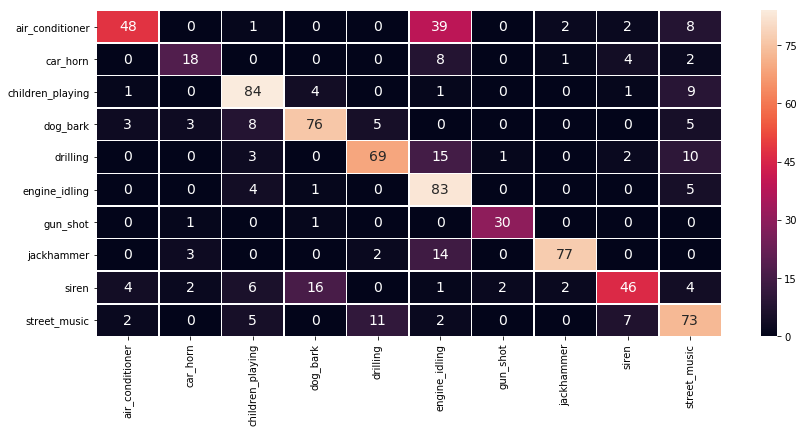

In [13]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, yticklabels=label_list,xticklabels=label_list)

In [14]:
def build_crnn2(n_features=n_features, n_frames=n_frames, n_filters_cnn=48,
                     filter_size_cnn=(3, 3), pool_size_cnn=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=( n_frames, n_features, 1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid', kernel_regularizer=l2(0.01),
               activation='relu')(x)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)
    
    y = TimeDistributed(Flatten())(y)
    
    #y = Reshape((n_filters_cnn,n_frames))(y)
    
    y = Dropout(0.5)(y)
    y= LSTM(120)(y)
    #y = Dropout(0.5)(y)
    #y = Dense(n_dense_cnn, activation='relu')(y)

    y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [19]:
from keras.utils import plot_model
plot_model(m, to_file='figures/crnn2_model.png', show_shapes=True)

<img src='figures/crnn_model2.png'>

In [ ]:
m = build_crnn2(n_features=40,)
m.summary()

In [ ]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(
    os.path.join(modelfolder, 'crnn2_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
    monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

history = m.fit(x=X_train, y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_split=0.0,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

In [ ]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

In [ ]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, yticklabels=label_list,xticklabels=label_list)